# 📊 Exploratory Data Analysis: Synthetic Sales Data

## 1. Environment Setup
In this section, we import the necessary libraries for data manipulation (`pandas`, `numpy`) and visualization (`matplotlib`, `seaborn`). We also configure the plotting aesthetics to ensuring high-readability for the charts.

In [1]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Plotting Aesthetics
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

print("✅ Libraries Loaded")

✅ Libraries Loaded


## 2. Data Ingestion
We load the **Synthetic Data** generated by our pipeline (`src/datagen.py`). This dataset simulates 5 years of daily sales records, injected with specific mathematical properties (Trend, Seasonality, and Noise) to test the robustness of our **Armstrong Cycle Transformer**.

In [2]:
# Load the Synthetic Data generated by our pipeline
# Ensure you have run 'python main.py' first so this file exists!
data_path = 'data/processed/synthetic_sales.csv'

try:
    df = pd.read_csv(data_path, parse_dates=['date'])
    df.set_index('date', inplace=True)
    print(f"✅ Data Loaded: {df.shape[0]} days of sales data")
    print(f"📅 Range: {df.index.min()} to {df.index.max()}")
except FileNotFoundError:
    print("❌ Error: Run 'src/datagen.py' first to generate the data!")

df.head()

✅ Data Loaded: 1827 days of sales data
📅 Range: 2015-01-01 00:00:00 to 2020-01-01 00:00:00


,seasonality,trend,noise,sales_amt
date,,,,
2015-01-01,0.000000,0,-3828.021513,16171.978487
2015-01-02,86.066781,10,4184.454781,24280.521562
2015-01-03,172.108058,20,-1211.678127,18980.429931
2015-01-04,258.098336,30,-147.826766,20140.271570
2015-01-05,344.012134,40,1430.044155,21814.056289


## 3. Visual Inspection (The "Eye Test")
Before applying complex models, we visualize the raw time series to confirm the data looks realistic.
* **Blue Line:** Actual Daily Sales (noisy).
* **Red Line:** 30-Day Moving Average (smooth).

**Goal:** We expect to see a general upward trend (Growth) and repeating yearly waves (Seasonality).

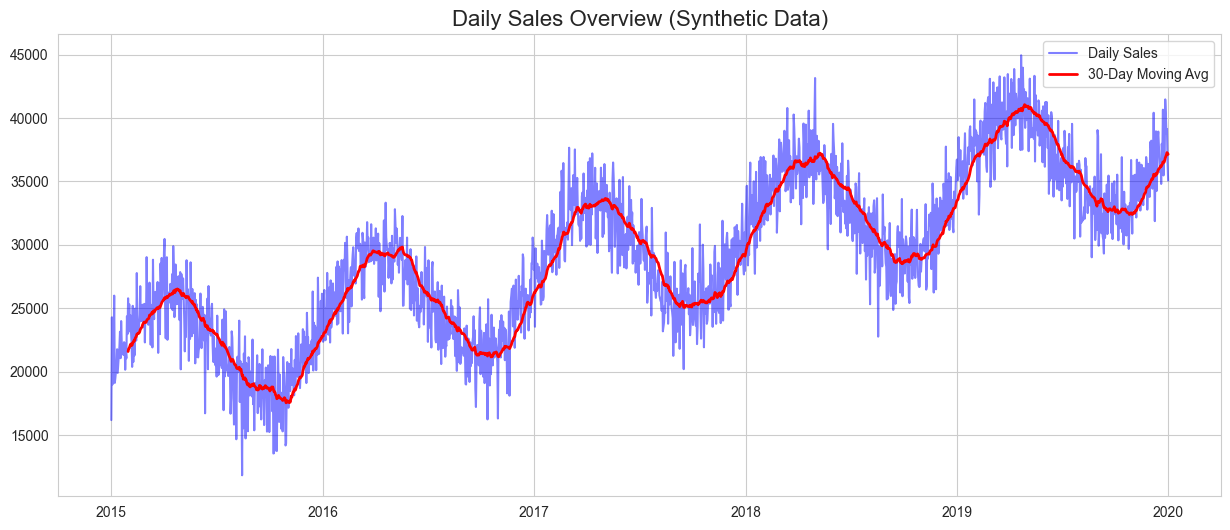

In [3]:
# 1. Plot Daily Sales
plt.figure(figsize=(15, 6))
plt.plot(df['sales_amt'], label='Daily Sales', color='blue', alpha=0.5)
plt.plot(df['sales_amt'].rolling(30).mean(), label='30-Day Moving Avg', color='red', linewidth=2)
plt.title('Daily Sales Overview (Synthetic Data)', fontsize=16)
plt.legend()
plt.show()

# Insight: The Red line shows the underlying trend and cycles clearly.

## 4. Time Series Decomposition
To scientifically validate the "waves" we see above, we use **Seasonal Decomposition**. This splits the time series into three distinct components:
1.  **Trend:** The long-term progression (Growth).
2.  **Seasonal:** The repeating short-term cycle (Yearly pattern).
3.  **Residual:** The random noise left over.

**Insight:** This confirms if our "Business Cycle" injection was successful.

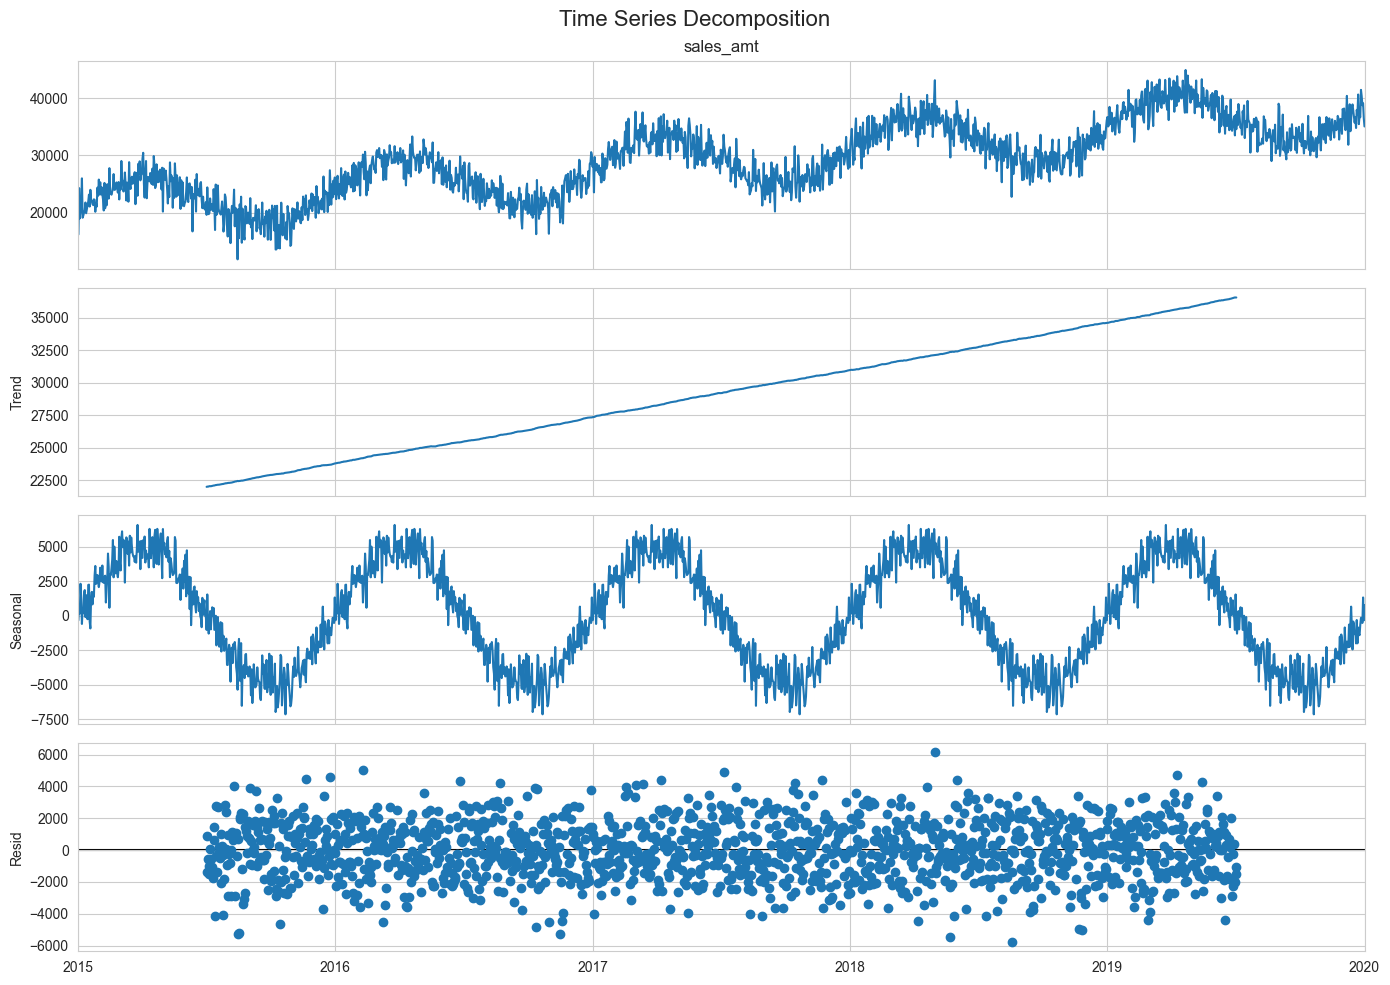

In [4]:
# Decompose the time series into Trend, Seasonal, and Residual components
# We use 'additive' because the seasonality magnitude looks constant over time
result = seasonal_decompose(df['sales_amt'], model='additive', period=365)

fig = result.plot()
fig.set_size_inches(14, 10)
plt.suptitle('Time Series Decomposition', fontsize=16)
plt.tight_layout()
plt.show()

## 5. Distribution Analysis
Many Machine Learning models (like Linear Regression) assume the target variable follows a **Normal (Gaussian) Distribution**. Here, we check the distribution of `sales_amt`.

* **Symmetrical Bell Curve:** Good for most models.
* **Skewed:** May require Log-Transformation before training.

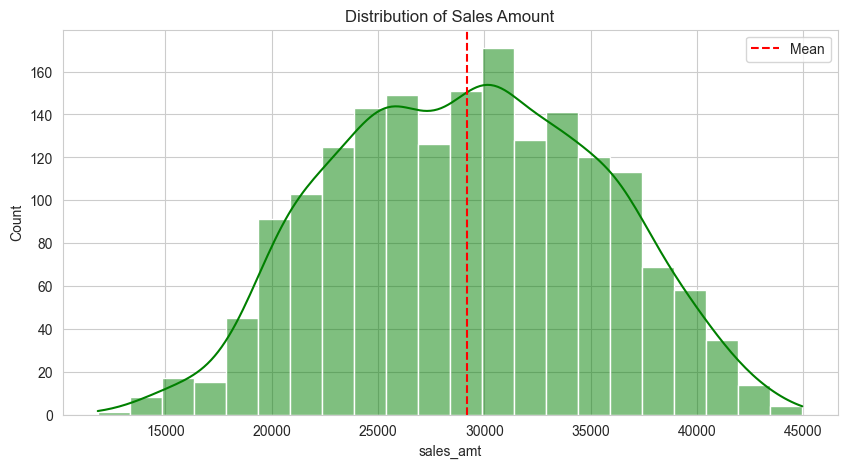

Skewness: 0.00


In [5]:
plt.figure(figsize=(10, 5))
sns.histplot(df['sales_amt'], kde=True, color='green')
plt.title('Distribution of Sales Amount')
plt.axvline(df['sales_amt'].mean(), color='red', linestyle='--', label='Mean')
plt.legend()
plt.show()

print(f"Skewness: {df['sales_amt'].skew():.2f}")
# If Skewness is > 1 or < -1, the data is highly skewed.

## 6. Validation of Armstrong Features
This is the critical test for our custom transformer. We manually recreate the **Armstrong Features** (Pi Cycle & Business Cycle) and calculate their statistical correlation with the actual Sales Amount.

* **High Correlation (Red):** The feature is a strong predictor.
* **Low Correlation (Blue):** The feature is weak or irrelevant.

**Goal:** We want to see a noticeable correlation between `biz_cycle` (our yearly wave) and `sales_amt`.

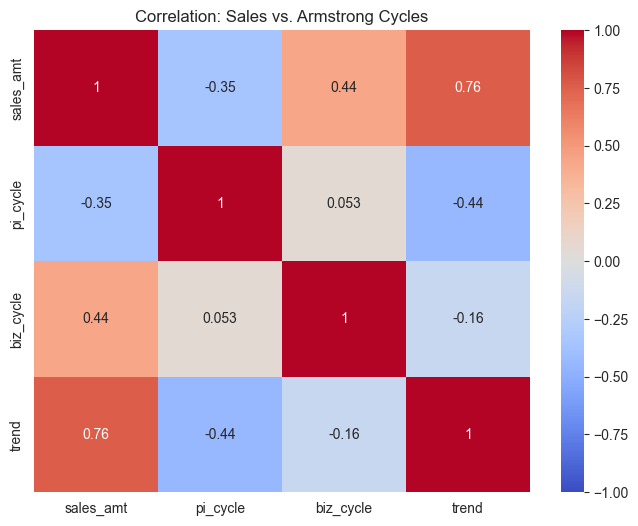

In [6]:
# Re-create the Armstrong Features specifically for EDA analysis
# (Ideally import the class, but for EDA we can quickly re-calc)
days_diff = (df.index - df.index[0]).days

df['pi_cycle'] = np.sin(2 * np.pi * days_diff / 3141)   # 8.6 Years
df['biz_cycle'] = np.sin(2 * np.pi * days_diff / 365.25) # 1 Year

# Correlation Matrix
corr = df[['sales_amt', 'pi_cycle', 'biz_cycle', 'trend']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation: Sales vs. Armstrong Cycles')
plt.show()

## 7. Strategic Model Selection & Conclusion
Based on the visual and statistical evidence gathered above, we evaluate which model architecture is best suited for this specific dataset.

## 📊 Model Selection Verdict based on EDA

### Observations
1.  **Strong Seasonality:** The decomposition plot confirms a clear 365-day repeating pattern.
2.  **Linear Trend:** There is a consistent upward growth (Trend component).
3.  **Non-Linearity:** The interaction between the sine waves and the noise creates complex local patterns.

### Evaluation of Candidates
* **Linear Regression:** ❌ Likely **Too Simple**. While it can capture the trend, it will struggle to fit the complex yearly "wiggles" unless we perform heavy feature engineering (Fourier terms).
* **ARIMA / SARIMA:** ⚠️ **Good but Slow**. Excellent for seasonality, but computationally expensive for high-frequency daily data over 5 years. Hard to automate in a pipeline.
* **Random Forest (Selected):** ✅ **Strong Contender**.
    * *Pros:* Can easily learn the non-linear interaction between the "Business Cycle" feature and Sales. Robust to the random noise injected in the data.
    * *Cons:* Cannot extrapolate the "Trend" indefinitely outside the training range (as seen in our 35% error).
* **XGBoost:** 🌟 **Best Potential**. Handles non-linearity like Random Forest but often generalizes better on gradients.

### Conclusion for Production
We will proceed with **Random Forest** for the MVP due to its stability and ease of implementation, but we acknowledge that **XGBoost** would be the next logical upgrade to reduce the error rate further.